In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.1 MB/s eta 0:00:00


In [ ]:
!unzip '/content/drive/MyDrive/hw-2/archive.zip' -d enror

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: enror/enron6/ham/4056.2001-07-25.lokay.ham.txt  
  inflating: enror/enron6/ham/4059.2001-07-27.lokay.ham.txt  
  inflating: enror/enron6/ham/4062.2001-07-30.lokay.ham.txt  
  inflating: enror/enron6/ham/4068.2001-07-30.lokay.ham.txt  
  inflating: enror/enron6/ham/4072.2001-07-30.lokay.ham.txt  
  inflating: enror/enron6/ham/4073.2001-07-31.lokay.ham.txt  
  inflating: enror/enron6/ham/4079.2001-07-31.lokay.ham.txt  
  inflating: enror/enron6/ham/4081.2001-08-01.lokay.ham.txt  
  inflating: enror/enron6/ham/4084.2001-08-01.lokay.ham.txt  
  inflating: enror/enron6/ham/4089.2001-08-01.lokay.ham.txt  
  inflating: enror/enron6/ham/4096.2001-08-01.lokay.ham.txt  
  inflating: enror/enron6/ham/4100.2001-08-01.lokay.ham.txt  
  inflating: enror/enron6/ham/4102.2001-08-02.lokay.ham.txt  
  inflating: enror/enron6/ham/4104.2001-08-02.lokay.ham.txt  
  inflating: enror/enron6/ham/4106.2001-08-02.lokay.ham.txt  
  

In [ ]:
# importing system libraries
import re
import pickle
import gensim
import random
import operator
import unicodedata
from os import walk
import os
from string import punctuation
from random import shuffle
from nltk.corpus import stopwords #import stopwords
from nltk.tokenize import word_tokenize
# importing additional libraries
from sklearn.cluster import DBSCAN, KMeans
import numpy as np
import pandas as pd
import sklearn as sk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def isExists(preload=False, path=''):
    if (not preload): return preload
    return os.path.exists(path)

In [ ]:
MAIN_PATH = '/content/drive/MyDrive/hw-2/toLoad'

In [ ]:
class LoadTexts():
    def __init__(self, txtPath):
        self.txtPath = txtPath
        self.allHamData = []
        self.allSpamData = []
        

    def __call__(self):
        if (not self.txtPath): return None
        self.load(self.txtPath)
        self.clear()
        newDict = {}
        newDict['email'] = self.allHamData
        newDict['spam'] = self.allSpamData
        return newDict
    
    def clear(self):
        self.allHamData = list(set(self.allHamData))
        self.allSpamData = list(set(self.allSpamData))
         

    def load(self, path):
        for curr in os.listdir(path):
            pathwalk = walk(os.path.join(path, curr))
            for root, dr, file in pathwalk:
                if 'ham' in str(root):
                    for obj in file:
                        with open(os.path.join(root, obj), encoding='latin1') as ip:
                            self.allHamData.append(" ".join(ip.readlines()))
                            
                elif 'spam' in str(root):
                    for obj in file:
                        with open(os.path.join(root, obj), encoding='latin1') as ip:
                            self.allSpamData.append(" ".join(ip.readlines()))                   

In [ ]:
class LoadTable():
    def __init__(self, MAIN_PATH = MAIN_PATH):
        self.table = None;
        

    def __call__(self, infoDict=None):
        self.infoDict = infoDict
        return self.toTable()

    def toTable(self):
        if (self.infoDict is None): return None
        allHamData = self.infoDict['email']
        allSpamData = self.infoDict['spam']
        hamPlusSpamData = allHamData + allSpamData
        labels = ["ham"]*len(allHamData) + ["spam"]*len(allSpamData)
        self.table = pd.DataFrame({"email": hamPlusSpamData, "label": labels})
        return self.table
        

In [ ]:
class PreprocessData():

    def __init__(self):
        return None
    
    def __call__(self, data):
        return self.preprocess(data)

    #стоп слова
    def stopword(self,string):
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(string)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        return ' '.join(filtered_sentence)

    def cleaning(self,string):
        #удаляем цифры из строк
        string = re.sub("\S*\d\S*", "", string).strip()
        #убираем хештеги
        string = re.sub('#[^\s]+','',string)
        #убираем упоминания через @
        string = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",string)

        #убирем строки, что не относятся к формату кодирования ASCII
        string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')

        #приводим к нижнему(единому) регистру
        string = string.lower()

        #удалям добавочные пробелы
        string = re.sub('[\s]+', ' ', string)
        return string
    def preprocess(self,data):
        #токенизация
        tokens = self.cleaning(data)
        tokens = "".join(tokens)
        
        #перечисление стоп-слов из NLTK
        stops = self.stopword(tokens)

        #лемматизация
        lemmatizer = nltk.WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(w, pos='a') for w in stops]
        
        tokens = "".join(tokens)
        return tokens

In [ ]:
class LabelEncoderLoader():
    def __init__(self, preload=False,name='label_encoder.pkl', MAIN_PATH = MAIN_PATH):
        self.currPath = os.path.join(MAIN_PATH,name)
        preload = isExists(preload, self.currPath)
        self.preload=preload
        self.label_encoder = sk.preprocessing.LabelEncoder()

        
    def __call__(self):
        if (self.preload):
            self.label_encoder = self.load()
        else:
            self.label_encoder = sk.preprocessing.LabelEncoder()
        return self

    
    def load(self):
        with open(self.currPath, 'rb') as f:
            return pickle.load(f)
    
    def save(self):
        with open(self.currPath, 'wb') as f:
            pickle.dump(self.label_encoder, f)

    def fit(self, labels):
        self.label_encoder.fit(labels)
        self.save()
    
    def transform(self, labels):
        if (self.preload):
            return self.label_encoder.transform(labels)
        else:
            self.fit(labels)
            return self.label_encoder.transform(labels)

In [ ]:
!mkdir -p '/content/test/test1' &&tar -xf '/content/drive/MyDrive/hw-2/test_task_emails.tar.xz' -C '/content/test/test1'

In [ ]:
!unzip '/content/drive/MyDrive/hw-2/archive_1.zip' -d '/content/test2'

In [ ]:
!unzip '/content/drive/MyDrive/hw-2/archive_2.zip' -d '/content/test3'

In [ ]:
class CorrTable():
    def __init__(self, preloadLabel=False):
        self.labelClass = LabelEncoderLoader(preloadLabel)()
        self.preprocessClass = PreprocessData()
        return None
    
    def __call__(self, raw_table = None):
        if (raw_table is None): return None
        return self.process(raw_table)
    
    def process(self, raw_table):
        emails = raw_table.email.apply(self.preprocessClass)
        labels = self.labelClass.transform(raw_table.label)
        return pd.DataFrame({'email': emails, 'label': labels})


In [ ]:
def load3(path):
    df = pd.read_csv(path)
    email = df[df.label==0].message.values
    spam = df[df.label==1].message.values
    newDict = {'email':email, 'spam':spam }
    return newDict

In [ ]:
MAIN_PATH = '/content/drive/MyDrive/hw/toLoad2/'

path33 = '/content/test2' 
path44 = '/content/test3/messages.csv'
path1 = '/content/enror'


preload1 = False

text1 = LoadTexts(path1)()
text2 = LoadTexts(path33)()
text3 = load3(path44)

text1['email'] = [*text1['email'],*text2['email'], *text3['spam']]
text1['spam'] = [*text1['spam'],*text2['spam'], *text3['spam']]

path5 = '/content/test'
preload5 = True
text5 = LoadTexts(path5)()

corrTableClass1 = CorrTable(preload1)
tableRaw1 = LoadTable()(text1)
df11 = corrTableClass1(tableRaw1)

corrTableClass5 = CorrTable(preload5)


tableRaw5 = LoadTable()(text5)


df55 = corrTableClass5(tableRaw5)

In [ ]:
import time, os
import transformers
import torch

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer,BertForSequenceClassification,AdamW,get_linear_schedule_with_warmup

In [ ]:
MODEL_TYPE = 'bert-base-uncased'


L_RATE = 1.5e-6
MAX_LEN = 512

NUM_EPOCHS = 10
BATCH_SIZE = 16
NUM_CORES = os.cpu_count()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [ ]:
class BetrToken():
    def __init__(self,name='model_spam',MAIN_PATH=MAIN_PATH):
        self.MODEL_TYPE = 'bert-base-uncased'
        self.currPath = os.path.join(MAIN_PATH,name)
        self.tokenizer = None
    
    def __call__(self, preload=False):
        preload = isExists(preload, self.currPath)
        if (preload):
            if (self.tokenizer):
                return self.tokenizer
            else:
                self.tokenizer = BertTokenizer.from_pretrained(self.currPath)
        else:
            self.tokenizer = BertTokenizer.from_pretrained(self.MODEL_TYPE)
        return self.tokenizer

    def save(self):
        self.tokenizer.save_pretrained(self.currPath)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
class PreprocessEndData():

    def __init__(self, batch_size=16):
        self.tokenizerRR = BetrToken()
        self.tokenizer = self.tokenizerRR(False)
        self.batch_size=batch_size

    def __call__(self,df, toTrain=True,max_length=512):
        labels_train = None
        train_sampler = torch.tensor([[]])
        tokenized_train=self.tokenizer.batch_encode_plus(df.email.tolist(),max_length=128,truncation=True, pad_to_max_length=True,return_tensors='pt')
        if (toTrain):
            labels_train=torch.from_numpy(np.array(df.label.values, dtype=np.int64))
            train_data=TensorDataset(tokenized_train['input_ids'],tokenized_train['attention_mask'],tokenized_train['token_type_ids'],labels_train)
        else:
            train_data=TensorDataset(tokenized_train['input_ids'],tokenized_train['attention_mask'],tokenized_train['token_type_ids'],)
        if (toTrain):
            train_sampler=RandomSampler(train_data)
            train_dataloader=DataLoader(train_data, sampler=train_sampler, batch_size=self.batch_size)
        else:
            train_dataloader=DataLoader(train_data, batch_size=self.batch_size)
        
        self.tokenizerRR.save()
        return train_dataloader

In [ ]:
path33 = '/content/test2' 
path44 = '/content/test3/messages.csv'
path1 = '/content/enror'

class E2ePreprocessData:
    def __init__(self,path1=None, path2=None, path3=None, toTrain=True, MAIN_PATH = MAIN_PATH):
        self.MAIN_PATH = MAIN_PATH
        self.loadTexts = LoadTexts(path1)
        self.toTrain = toTrain
        self.preload = not toTrain
        self.path1 = path1
        self.text1 = None
        if (toTrain):
            text1 = LoadTexts(path1)()
            text2 = LoadTexts(path2)()
            text3 = load3(path3)

            text1['email'] = [*text1['email'],*text2['email'], *text3['spam']]
            text1['spam'] = [*text1['spam'],*text2['spam'], *text3['spam']]
            self.text1 = text1
        
        self.infoLists = None
        self.raw_df = None
        pass
    
    def __call__(self):
        return self.process()
    
    def process(self):
        if (self.text1 is None):
            print(self.text1)
            self.text1 = self.loadTexts()
        tableRaw1 = LoadTable()(self.text1)
        corrTableClass1 = CorrTable(self.preload)
        return corrTableClass1(tableRaw1)
    
    def split(self, new_frames):
        return train_test_split(new_frames, random_state=2018, test_size=0.2)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path1 = '/content/enror'
path33 = '/content/test2' 
path44 = '/content/test3/messages.csv'
e2ePreprocess = E2ePreprocessData(path1,path33,path44)
new_frames = e2ePreprocess()

In [ ]:
path = '/content/test'
e2ePreprocess = E2ePreprocessData(path,  toTrain=False)
test_new_frames = e2ePreprocess()

In [ ]:
sum(new_frames.label==0)

19174

In [ ]:
19174/35636 * 100

53.80514086878437

In [ ]:
# train, val= e2ePreprocess.split(df11) 
# train, test= e2ePreprocess.split(train)
train, val = train_test_split(new_frames, random_state=2018, test_size=0.2)
train, test = train_test_split(train, random_state=2018, test_size=0.2)

In [ ]:
train_dataloader = PreprocessEndData()(train, max_length=128)
val_dataloader = PreprocessEndData()(val)
test_dataloader = PreprocessEndData()(test, False)
test_dataloader2 = PreprocessEndData()(test_new_frames)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
class BetrModel():
    def __init__(self,name='model_spam',MAIN_PATH=MAIN_PATH):
        self.MODEL_TYPE = 'bert-base-uncased'
        self.currPath = os.path.join(MAIN_PATH,name)
        self.model = None
    
    def __call__(self, preload=False):
        preload = isExists(preload, self.currPath)
        if (preload):
            if (self.model):
                return self.model
            else:
                self.model = BertForSequenceClassification.from_pretrained(self.currPath)
        else:
            self.model = BertForSequenceClassification.from_pretrained(self.MODEL_TYPE,num_labels=2,output_attentions=False,output_hidden_states=False)
        return self.model
    
    def save(self):
        self.model.save_pretrained(self.currPath)


In [ ]:
class ModelToTrain:

    def __init__(self, preload=False):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.modelClass = BetrModel()
        self.model = self.modelClass(preload)
        self.model.cuda()
        self.optimizer=torch.optim.AdamW(self.model.parameters(),lr=1.5e-6)
        seed_val = 12
        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)
        self.loss_values = []
        self.avg_values = []

    def test_on_data(self, test_dataloader):
        #Отслеживаем переменные
        val_accuracy=0
        nb_val_steps=0

        #Тестим данные на одной эпохе
        for batch in test_dataloader:
            #Перезаписываем данные на gpu
            batch = tuple(t.to(self.device) for t in batch)
            
            #Распакуем
            b_input_ids,b_attention_mask, b_token_type, b_labels = batch
            
            #Говорим модельке не обучаться. Сохраним память и увеличим скорость проверки
            with torch.no_grad():        
                outputs = self.model(b_input_ids,token_type_ids=b_token_type,attention_mask=b_attention_mask)
            
            #Получим вывод "логитов" модели. Эти «логиты» являются выходными значениями до применения функции активации, такой как softmax.
            logits = outputs[0]
            
            #Перезаписываем данные на gpu
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            #Считаем точность этого батча на тестовых предложениях
            tmp_val_accuracy = self.flat_accuracy(logits, label_ids)
            
            #Добавляем в копилку итоговой точности
            val_accuracy += tmp_val_accuracy

            #Отслеживаем номер батча
            nb_val_steps += 1
        avg_val_acc = val_accuracy/nb_val_steps
        self.avg_values.append(avg_val_acc)
        # Сообщаем итоговую точность на проверочной выборке
        print("  Точность: {0:.2f}".format(val_accuracy/nb_val_steps))         

    
    def fit_on_data(self, train_dataloader):
        total_loss=0
        for step, batch in enumerate(train_dataloader):

            #Clear previously calculated gradients before performing a backward pass
            self.model.zero_grad() 

            #Распаковываем обучающий батч
            b_input_ids = batch[0].to(device)
            b_attention_mask=batch[1].to(device)
            b_token_type = batch[2].to(device)
            b_labels = batch[3].to(device)


            #Выполняем прямое распространение и получаем loss(ошибку)
            outputs=self.model(b_input_ids,token_type_ids=b_token_type,attention_mask=b_attention_mask,labels=b_labels)
            
            loss = outputs[0]
            total_loss += loss.item()

            #Выполняем обратный проход и считаем градиенты
            loss.backward()

            #Обрезаем норму градиентов до 1.0
            #Используется для предотвращения проблемы "взрыва градиентов"
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            #Обновляем веса
            self.optimizer.step()

            #Обновляем шаг изменения весов
            self.scheduler.step()

        #Средняя ошибка на обучающей выборке за эпоху
        avg_train_loss = total_loss / len(train_dataloader)
        self.loss_values.append(avg_train_loss)
        print("")
        print("  Средняя ошибка на обучающей выборке: {0:.2f}".format(avg_train_loss))
    

    def fit(self, loader, test, epochs=5):
        self.epochs=5
        self.total_steps=len(loader)*epochs
        self.scheduler=get_linear_schedule_with_warmup(self.optimizer,num_warmup_steps=0,num_training_steps = self.total_steps)

        for epoch_i in range(0, epochs):
            print("")
            print('======== Эпоха {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Обучение...')
            self.model.train()
            self.fit_on_data(loader)
            self.model.eval()
            self.test_on_data(test)
        
        self.modelClass.save()

    
        # Функция для подсчёта точности предсказния
    def flat_accuracy(self,preds, labels):
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
model = ModelToTrain()
model.fit(train_dataloader, test_dataloader2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Эпоха 1 / 5 ========
Обучение...

  Средняя ошибка на обучающей выборке: 0.24
  Точность: 0.81

======== Эпоха 2 / 5 ========
Обучение...

  Средняя ошибка на обучающей выборке: 0.13
  Точность: 0.76

======== Эпоха 3 / 5 ========
Обучение...

  Средняя ошибка на обучающей выборке: 0.11
  Точность: 0.75

======== Эпоха 4 / 5 ========
Обучение...

  Средняя ошибка на обучающей выборке: 0.09
  Точность: 0.77

======== Эпоха 5 / 5 ========
Обучение...

  Средняя ошибка на обучающей выборке: 0.09
  Точность: 0.74


Text(0, 0.5, 'Точность')

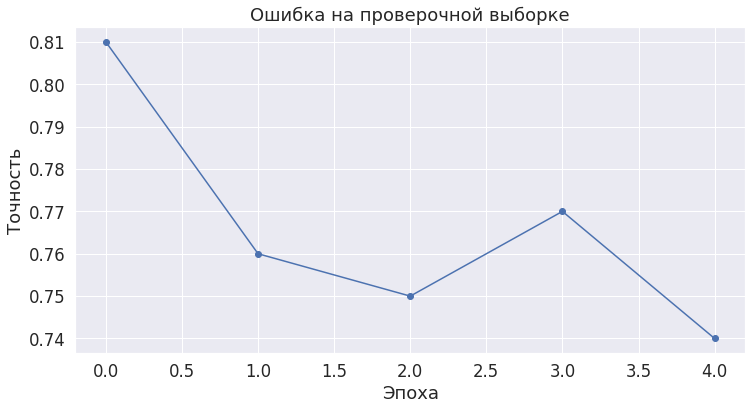

In [ ]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot([0.81, 0.76, 0.75, 0.77, 0.74], 'b-o')
plt.title("Ошибка на проверочной выборке")
plt.xlabel("Эпоха")
plt.ylabel("Точность")

In [ ]:
model.test_on_data(val_dataloader)

  Точность: 0.97


In [ ]:
model.test_on_data(test_dataloader2)

  Точность: 0.74


In [ ]:
final_output = []
for batch in test_dataloader2:
  #Перезаписываем данные на gpu
  batch = tuple(t.to(device) for t in batch)
  
  #Распакуем
  b_input_ids,b_attention_mask, b_token_type, _= batch
  
  #Говорим модельке не обучаться. Сохраним память и увеличим скорость проверки
  with torch.no_grad():        
      outputs = model.model(b_input_ids,token_type_ids=b_token_type,attention_mask=b_attention_mask)
  
  #Получим вывод "логитов" модели. Эти «логиты» являются выходными значениями до применения функции активации, такой как softmax.
  logits = outputs[0]
  final_output.extend(np.argmax(logits.detach().cpu().numpy(), axis=1).flatten())

In [ ]:
lbl = test_new_frames['label']

In [ ]:
output = pd.DataFrame({'email': test.email, 'true_label':lbl,
                       'prediction': final_output})
output.to_csv('/content/drive/MyDrive/hw/toLoad/bert 1.5e-6.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class getInfo:
    def __init__(self, lossName='Training loss',accName='Validation accuracy',MAIN_PATH=MAIN_PATH):
        self.lossPath = os.path.join(MAIN_PATH,lossName)
        self.accPath = os.path.join(MAIN_PATH,accName)

    def getLoss(self, loss_values):
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        # Plot the learning curve.
        plt.plot(loss_values, 'b-o')

        # Label the plot.
        plt.title("Ошибка на обучающей выборке")
        plt.xlabel("Эпоха")
        plt.ylabel("Ошибка")
        plt.savefig(self.lossPath)
        plt.show()
    
    def getAcc(self, avg_values):
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        # Plot the learning curve.
        plt.plot(avg_values, 'b-o')

        # Label the plot.
        plt.title("Ошибка на проверочной выборке")
        plt.xlabel("Эпоха")
        plt.ylabel("Точность")
        plt.savefig("/content/drive/MyDrive/hw/toLoad/Validation accuracy")
        plt.show()

In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score, confusion_matrix

# Объединим все предсказния для каждого батча в один лист первых и вторых классов
flat_predictions = [item for item in final_output]
#flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Объединим все корректные метки для каждого батча в один лист первых и вторых классов
flat_true_labels = [item for item in lbl]

# Подсчитаем F1
f1 = f1_score(flat_true_labels, flat_predictions,average='macro')

rec = recall_score(flat_true_labels, flat_predictions,average='macro')

pre = precision_score(flat_true_labels, flat_predictions,average='macro')

print('F1 метрика для  BERT: %.3f' % f1)
print('Recall метрика для BERT: %.3f' % rec)
print('Precision метрика для BERT: %.3f' % pre)

F1 метрика для  BERT: 0.473
Recall метрика для BERT: 0.502
Precision метрика для BERT: 0.502


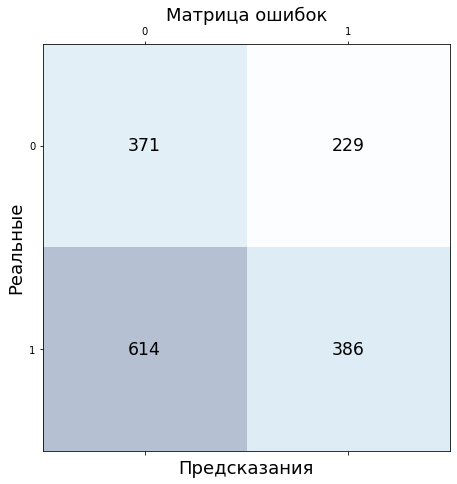

In [ ]:
conf_matrix = confusion_matrix(y_true=lbl, y_pred=flat_predictions)
#
# Выведем матрицу ошибок используя Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Предсказания', fontsize=18)
plt.ylabel('Реальные', fontsize=18)
plt.title('Матрица ошибок', fontsize=18)
plt.show()

In [ ]:
import os

# Сохраняем лучшие веса: если использовать дефолтное имя для модели, ты можешь предзагрузить её используя from_pretrained

output_dir = '/content/drive/MyDrive/hw/toLoad/model_spam'

# Создаём директорию, если требуется
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Сохраняем модель в %s" % output_dir)

# Сохраняем предобученную модель, конфиг и токенизатор используя `save_pretrained()`
# Они могут быть загружены снова используя `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Следите за параллельными обучениями
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Сохраняем модель в /content/drive/MyDrive/hw/toLoad/model_spam


('/content/drive/MyDrive/hw/toLoad/model_spam/tokenizer_config.json',
 '/content/drive/MyDrive/hw/toLoad/model_spam/special_tokens_map.json',
 '/content/drive/MyDrive/hw/toLoad/model_spam/vocab.txt',
 '/content/drive/MyDrive/hw/toLoad/model_spam/added_tokens.json')

In [ ]:
tokenizer2 = BertTokenizer.from_pretrained('/content/drive/MyDrive/hw/toLoad/model_spam')
model2 =BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/hw/toLoad/model_spam')